<a href="https://colab.research.google.com/github/rockowtham/eip_class/blob/class5/Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/eipdata/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
replace resized/9733.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

KeyboardInterrupt: ignored

In [0]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
import seaborn as sns

In [0]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


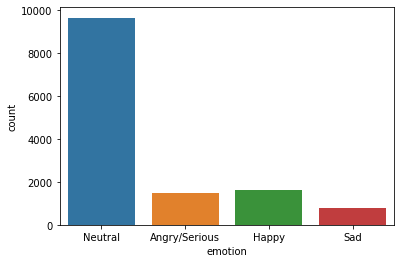

In [0]:

sns.countplot(x='emotion',data=df)

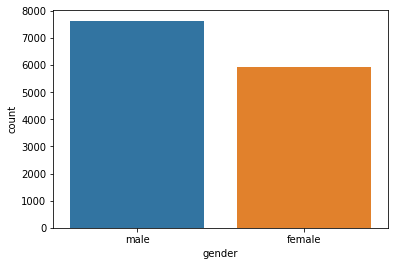

In [0]:
sns.countplot(x='gender',data=df)

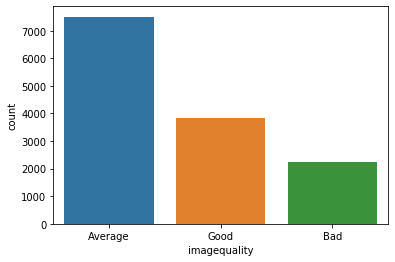

In [0]:

sns.countplot(x='imagequality',data=df)

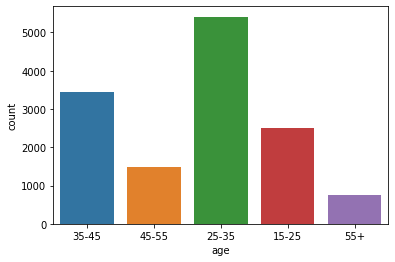

In [0]:

sns.countplot(x='age',data=df)

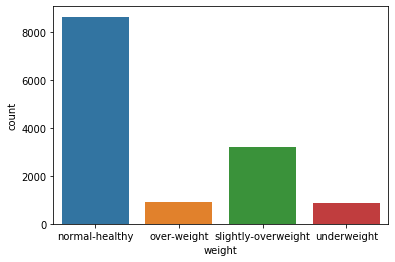

In [0]:

sns.countplot(x='weight',data=df)

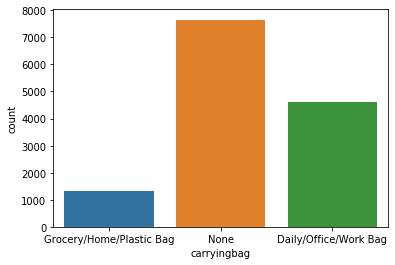

In [0]:
sns.countplot(x='carryingbag',data=df)

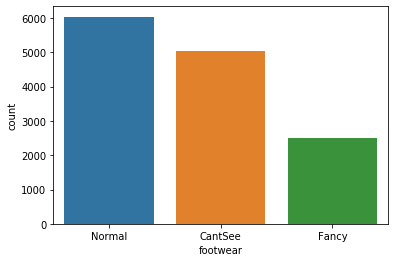

In [0]:
sns.countplot(x='footwear',data=df)

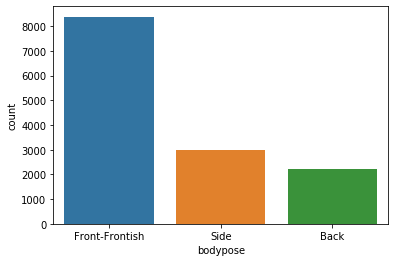

In [0]:
sns.countplot(x='bodypose',data=df)

In [0]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg,resized/6.jpg,resized/7.jpg,resized/8.jpg,resized/9.jpg,resized/10.jpg
gender_female,0,1,0,0,1,0,0,0,0,0
gender_male,1,0,1,1,0,1,1,1,1,1
imagequality_Average,1,1,0,0,0,0,0,0,1,1
imagequality_Bad,0,0,0,0,0,0,1,0,0,0
imagequality_Good,0,0,1,1,1,1,0,1,0,0
age_15-25,0,0,0,0,0,0,0,0,0,0
age_25-35,0,0,0,0,0,0,1,1,0,1
age_35-45,1,1,0,0,1,1,0,0,1,0
age_45-55,0,0,1,1,0,0,0,0,0,0


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    def __init__(self, df, batch_size=32, shuffle=True, augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        
        images = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])        
        if self.augmentation is not None:
            images = self.augmentation.flow(images, shuffle=False).next()
        
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        
        return images, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
1930,resized/1931.jpg,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0
9693,resized/9694.jpg,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0
1572,resized/1573.jpg,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
2994,resized/2995.jpg,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0
10251,resized/10253.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0


In [0]:
# create train and validation data generators
# train_gen = PersonDataGenerator(train_df, batch_size=64)
train_gen = PersonDataGenerator(
    train_df, 
    batch_size=32, shuffle=True,
    augmentation=ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
    )
)
valid_gen = PersonDataGenerator(
    val_df, 
    batch_size=32, shuffle=True,
    augmentation=ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
    )
)
# valid_gen = PersonDataGenerator(val_df, batch_size=128, shuffle=True)

In [0]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

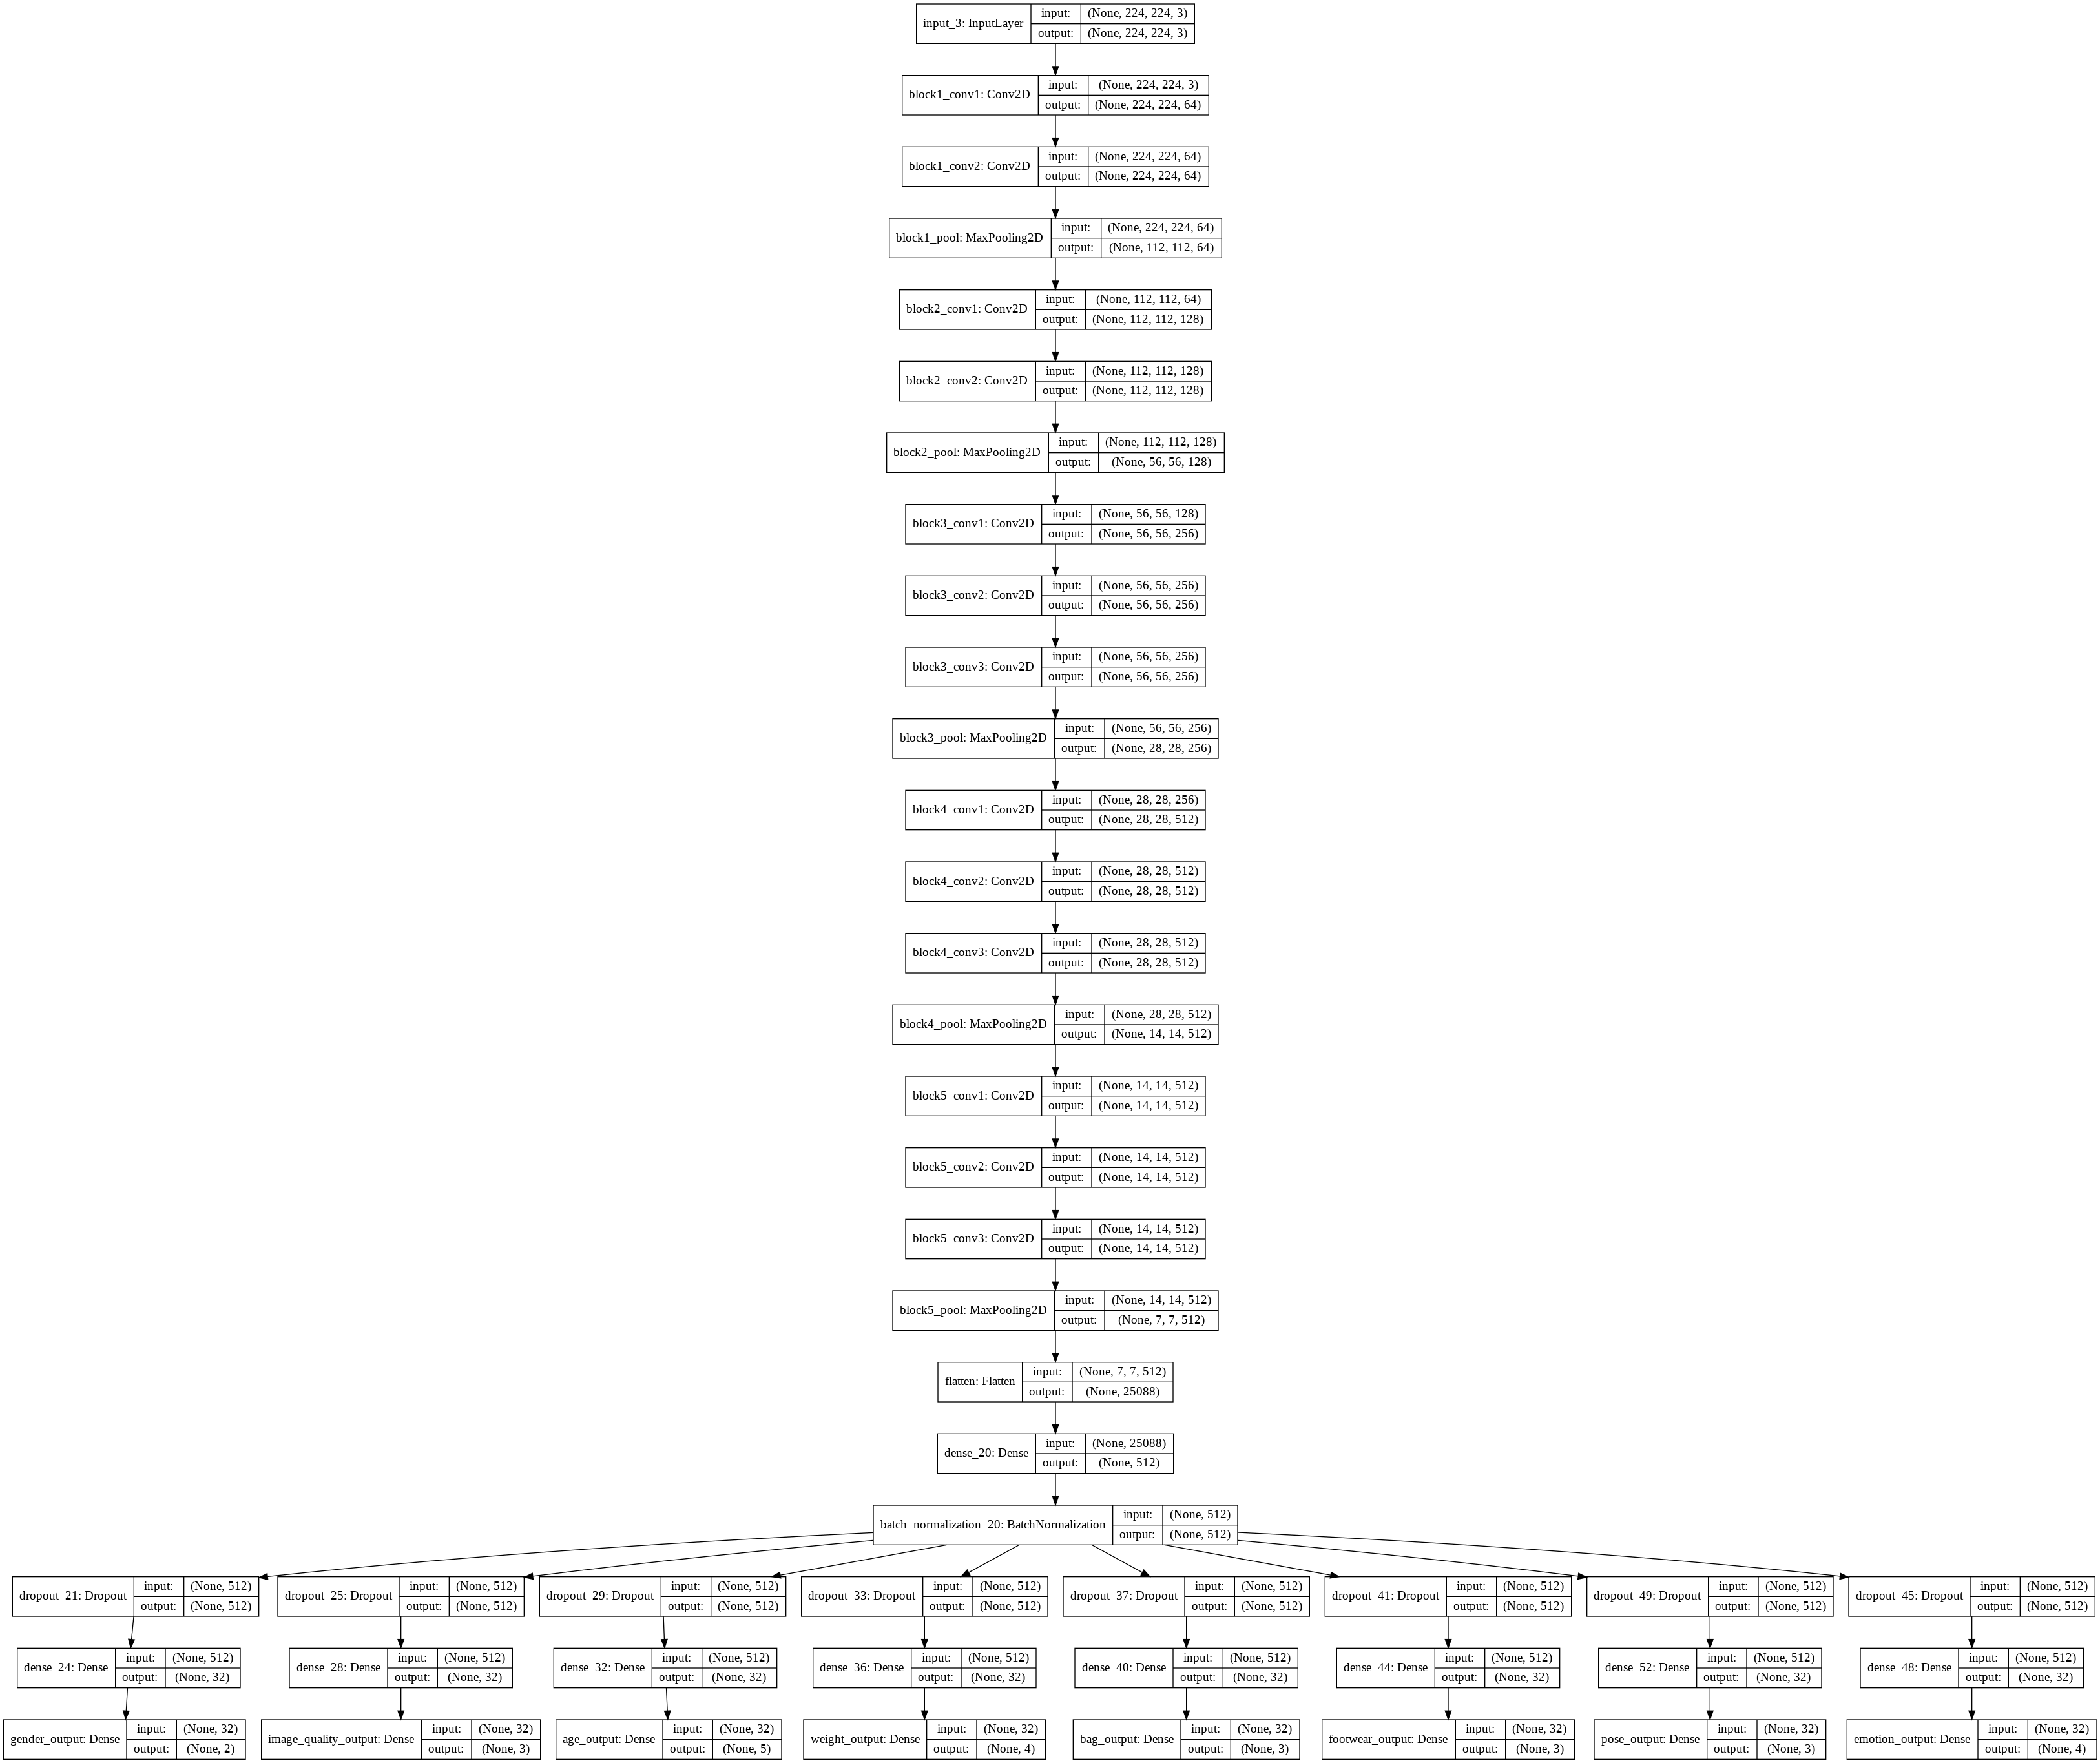

In [0]:
backbone = VGG16(
    weights="imagenet", 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)
neck = BatchNormalization()(neck)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(256, activation="relu")(neck)
    neck = MaxPooling2D(pool_size=(2, 2))
    # neck = BatchNormalization()(neck)
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = MaxPooling2D(pool_size=(2, 2))
    # neck = BatchNormalization()(neck)
    neck = Dropout(0.25)(in_layer)
    neck = Dense(64, activation="relu")(neck)
    neck = MaxPooling2D(pool_size=(2, 2))
    # neck = BatchNormalization()(neck)
    neck = Dropout(0.25)(in_layer)
    neck = Dense(32, activation="relu")(neck)

    # neck = Dropout(0.2)(in_layer)
    # neck = Dense(128, activation="relu")(neck)
    # neck = BatchNormalization()(neck)
    # neck = Dropout(0.3)(in_layer)
    # # neck = MaxPooling2D(pool_size=(2, 2))
    # neck = Dense(128, activation="relu")(neck)
    # neck = BatchNormalization()(neck)

    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
# freeze backbone
for layer in backbone.layers:
	layer.trainable = False

In [0]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
import os
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1
n = 3
# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 15:
        lr *= 0.5e-3
    elif epoch > 20:
        lr *= 1e-3
    elif epoch > 10:
        lr *= 1e-1
    elif epoch > 25:
        lr *= 0.25e-5
    print('Learning rate: ', lr)
    return lr

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# losses = {
# 	"gender_output": "binary_crossentropy",
# 	"image_quality_output": "categorical_crossentropy",
# 	"age_output": "categorical_crossentropy",
# 	"weight_output": "categorical_crossentropy",

# }
# loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
# opt = Adam(lr=lr_schedule(0))
# model.compile(
#     optimizer=opt,
#     loss="categorical_crossentropy", 
#     # loss_weights=loss_weights, 
#     metrics=["accuracy"]
# )

Learning rate:  0.001


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________

In [0]:
# model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=10)

In [34]:
 model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=35, 
    epochs=50,
    verbose=1,
    callbacks=callbacks
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
Learning rate:  0.001
360/360 [==============================] - 70s 196ms/step - loss: 9.5454 - gender_output_loss: 0.6526 - image_quality_output_loss: 1.1497 - age_output_loss: 1.8842 - weight_output_loss: 1.4637 - bag_output_loss: 1.1367 - footwear_output_loss: 1.0842 - pose_output_loss: 0.9509 - emotion_output_loss: 1.2233 - gender_output_acc: 0.6766 - image_quality_output_acc: 0.4662 - age_output_acc: 0.2317 - weight_output_acc: 0.4565 - bag_output_acc: 0.4823 - footwear_output_acc: 0.5519 - pose_output_acc: 0.5949 - emotion_output_acc: 0.5939 - val_loss: 7.8867 - val_gender_output_loss: 0.5124 - val_image_quality_output_loss: 0.9897 - val_age_output_loss: 1.6163 - val_weight_output_loss: 1.1076 - val_bag_output_loss: 0.9767 - val_footwear_output_loss: 0.9231 - val_pose_output_loss: 0.7000 - val_emotion_output_loss: 1.0609 - val_gender_output_acc: 0.7525 - val_image_quality_o

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/50
Learning rate:  0.001
  2/360 [..............................] - ETA: 3:27 - loss: 7.9861 - gender_output_loss: 0.5784 - image_quality_output_loss: 0.8692 - age_output_loss: 1.7876 - weight_output_loss: 1.1081 - bag_output_loss: 0.9232 - footwear_output_loss: 0.9335 - pose_output_loss: 0.7029 - emotion_output_loss: 1.0832 - gender_output_acc: 0.7344 - image_quality_output_acc: 0.6094 - age_output_acc: 0.2812 - weight_output_acc: 0.6094 - bag_output_acc: 0.6250 - footwear_output_acc: 0.5938 - pose_output_acc: 0.6875 - emotion_output_acc: 0.6562Learning rate: 0.001
Epoch 3/50
Learning rate:  0.001
360/360 [==============================] - 61s 170ms/step - loss: 7.4321 - gender_output_loss: 0.4901 - image_quality_output_loss: 0.9643 - age_output_loss: 1.5006 - weight_output_loss: 1.0730 - bag_output_loss: 0.9132 - footwear_output_loss: 0.8727 - pose_output_loss: 0.6577 - emotion_output_loss: 0.9605 - gender_output_acc: 0.7686 - image_quality_output_acc: 0.5461 - age_output_acc

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 106 could not be retrieved. It could be because a worker has died.
  UserWarning)


360/360 [==============================] - 110s 305ms/step - loss: 6.1369 - gender_output_loss: 0.3690 - image_quality_output_loss: 0.8280 - age_output_loss: 1.2815 - weight_output_loss: 0.8830 - bag_output_loss: 0.7613 - footwear_output_loss: 0.7017 - pose_output_loss: 0.4959 - emotion_output_loss: 0.8165 - gender_output_acc: 0.8329 - image_quality_output_acc: 0.6125 - age_output_acc: 0.4604 - weight_output_acc: 0.6559 - bag_output_acc: 0.6592 - footwear_output_acc: 0.6989 - pose_output_acc: 0.8002 - emotion_output_acc: 0.7123 - val_loss: 6.9770 - val_gender_output_loss: 0.3681 - val_image_quality_output_loss: 0.9262 - val_age_output_loss: 1.4285 - val_weight_output_loss: 1.0054 - val_bag_output_loss: 0.8746 - val_footwear_output_loss: 0.8241 - val_pose_output_loss: 0.5693 - val_emotion_output_loss: 0.9808 - val_gender_output_acc: 0.8373 - val_image_quality_output_acc: 0.5496 - val_age_output_acc: 0.3735 - val_weight_output_acc: 0.6324 - val_bag_output_acc: 0.6220 - val_footwear_outpu

Process ForkPoolWorker-1925:
Process ForkPoolWorker-1900:
Process ForkPoolWorker-1910:
Process ForkPoolWorker-1907:
Process ForkPoolWorker-1975:
Process ForkPoolWorker-1982:
Process ForkPoolWorker-1918:
Process ForkPoolWorker-1913:
Process ForkPoolWorker-1905:
Process ForkPoolWorker-1974:
Process ForkPoolWorker-1978:
Process ForkPoolWorker-1967:
Process ForkPoolWorker-1917:
Process ForkPoolWorker-1894:
Process ForkPoolWorker-1964:
Process ForkPoolWorker-1980:
Process ForkPoolWorker-1977:
Process ForkPoolWorker-1902:
Process ForkPoolWorker-1916:
Process ForkPoolWorker-1908:
Process ForkPoolWorker-1966:
Process ForkPoolWorker-1923:
Process ForkPoolWorker-1909:
Process ForkPoolWorker-1911:
Process ForkPoolWorker-1892:
Process ForkPoolWorker-1993:
Process ForkPoolWorker-1971:
Process ForkPoolWorker-1962:
Process ForkPoolWorker-1906:
Process ForkPoolWorker-1969:
Process ForkPoolWorker-1961:
Traceback (most recent call last):
Process ForkPoolWorker-1919:
Process ForkPoolWorker-1970:
Process 

KeyboardInterrupt: ignored

  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/pyth

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-34-e815d9f8764a>", line 8, in <module>
    callbacks=callbacks
  File "/usr/local/lib/python3.6/dist-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training.py", line 1658, in fit_generator
    initial_epoch=initial_epoch)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py", line 181, in fit_generator
    generator_output = next(output_generator)
  File "/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py", line 602, in get
    future = self.queue.get(block=True)
  File "/usr/lib/python3.6/queue.py", line 164, in get
    self.not_empty.wait()
  File "/usr/lib/python3.6/threading.py", line 295, in wait
    waiter.acquire()
Keybo

In [35]:
results = model.evaluate_generator(valid_gen, verbose=1)
dict(zip(model.metrics_names, results))

63/63 [==============================] - 6s 102ms/step


{'age_output_acc': 0.3834325396825397,
 'age_output_loss': 1.434491585171412,
 'bag_output_acc': 0.6195436507936508,
 'bag_output_loss': 0.8713655282580663,
 'emotion_output_acc': 0.6810515873015873,
 'emotion_output_loss': 0.9786540894281297,
 'footwear_output_acc': 0.6359126984126984,
 'footwear_output_loss': 0.8322568110057286,
 'gender_output_acc': 0.8263888888888888,
 'gender_output_loss': 0.38312548730108476,
 'image_quality_output_acc': 0.5481150793650794,
 'image_quality_output_loss': 0.9299619756047688,
 'loss': 7.000939543285067,
 'pose_output_acc': 0.7767857142857143,
 'pose_output_loss': 0.5546868365435373,
 'weight_output_acc': 0.6314484126984127,
 'weight_output_loss': 1.0163972349393935}